In [1]:
# get rid of some chemprop warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Training Chemprop models using QSPRpred

This notebook demonstrates how to train Chemprop models using QSPRpred.
Chemprop is a library for training and evaluating message passing neural networks for molecular property prediction [1, 2, 3].
Using QSPRpred, we have wrapped Chemprop to allow for training Chemprop models using QSPRpred.
Not all functionality of Chemprop is available through QSPRpred, but we hope to expand this in the future.

1. Yang K, et al. Analyzing Learned Molecular Representations for Property Prediction. J Chem Inf Model. 2019;59(8):3370-3388. doi:10.1021/acs.jcim.9b00237
2. Heid E, et al. Chemprop: Machine Learning Package for Chemical Property Prediction. ChemRxiv. 2023; doi:10.26434 chemrxiv-2023-3zcfl (preprint)
3. https://github.com/chemprop/chemprop

Let's start by preparing the data, which is identical to the data preparation in other tutorials.
With the exception that we need to specify that we want to use SMILES strings as features.
It is possible to use other features in addition to SMILES strings, but the SMILES strings must be included in the features as input for the message passing neural network.

Chemprop also provides the option to specify custom atom and bond features, but this is not (yet) supported in QSPRpred.

In [2]:
import os

from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.data.descriptors.sets import SmilesDesc

os.makedirs("../../tutorial_output/data", exist_ok=True)

# Create dataset
dataset = QSPRDataset.fromTableFile(
    filename="../../tutorial_data/A2A_LIGANDS.tsv",
    store_dir="../../tutorial_output/data",
    name="ChempropTutorialDataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
    random_state=42
)

# calculate compound features and split dataset into train and test
feature_calculators = [SmilesDesc(), MorganFP(radius=3, nBits=2048)]
dataset.prepareDataset(
    split=RandomSplit(test_fraction=0.2, dataset=dataset),
    feature_calculators=feature_calculators,
    recalculate_features=True,
)

dataset.getDF().head()

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


,SMILES,pchembl_value_Mean,Year,QSPRID,pchembl_value_Mean_original
QSPRID,,,,,
ChempropTutorialDataset_0000,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,8.68,2008.0,ChempropTutorialDataset_0000,8.68
ChempropTutorialDataset_0001,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2nc3c(cc12...,4.82,2010.0,ChempropTutorialDataset_0001,4.82
ChempropTutorialDataset_0002,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0,ChempropTutorialDataset_0002,5.65
ChempropTutorialDataset_0003,CNC(=O)C12CC1C(n1cnc3c(NCc4cccc(Cl)c4)nc(C#CCC...,5.45,2009.0,ChempropTutorialDataset_0003,5.45
ChempropTutorialDataset_0004,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0,ChempropTutorialDataset_0004,5.20


After preparing the data, we can train a model.
Initizalizing a `ChempropModel` is identical to initializing other `QSPRModel` models.
We can specify set `quiet_logger` to False to get the debug output from Chemprop.

As not all Chemprop functionality is available through QSPRpred, some parameters are not used in QSPRpred.
Therefore, a convienience function `getAvailableParameters` is provided to get a dictionary of the arguments that are used in QSPRpred.
Definitions and default values may be found on the Chemprop github (https://github.com/chemprop/chemprop/blob/master/chemprop/args.py).

In [3]:
from qsprpred.extra.gpu.models.chemprop import ChempropModel

ChempropModel.getAvailableParameters()

{'no_cuda': 'Turn off cuda (i.e., use CPU instead of GPU).',
 'gpu': 'Which GPU to use.',
 'num_workers': 'Number of workers for the parallel data loading (0 means sequential).',
 'batch_size': 'Batch size.',
 'no_cache_mol': 'Whether to not cache the RDKit molecule for each SMILES string to reduce memory usage (cached by default).',
 'empty_cache': 'Whether to empty all caches before training or predicting. This is necessary if multiple jobs are run within a single script and the atom or bond features change.',
 'loss_function': 'Choice of loss function. Loss functions are limited to compatible dataset types.',
 'metric': "Metric to use with the validation set for early stopping. Defaults to 'auc' for classification, 'rmse' for regression. Note. In Chemprop this metric is also used for test-set evaluation, but in QSPRpred this is determined by the scoring parameter in assessment.",
 'bias': 'Whether to add bias to linear layers.',
 'hidden_size': 'Dimensionality of hidden layers in MP

We will use default parameters, except for the number of epochs, which we will set to 5 for demonstration purposes.

In [4]:
# Create model
os.makedirs("../../tutorial_output/models", exist_ok=True)
model = ChempropModel(
    base_dir='../../tutorial_output/models',
    name='ChempropTutorialModel',
    parameters={"epochs": 5},
    quiet_logger=False
)

Training a `ChempropModel` works the same as training another `QSPRModel` that supports early stopping.
Have a look at the [deep learning tutorial](../../basics/data/data_splitting.ipynb) for more information on early stopping.

In [5]:
from qsprpred.models import CrossValAssessor, TestSetAssessor
from qsprpred.models.early_stopping import EarlyStoppingMode

# We can now assess the model performance on the training set using cross validation
CrossValAssessor('r2')(model, dataset)

# and on the test set
TestSetAssessor('r2')(model, dataset)

# Finally, we need to fit the model on the complete dataset if we want to use it further
# This will save the fitted model and metadata to disk
model.earlyStopping.numEpochs = 5
model.fitDataset(dataset, mode=EarlyStoppingMode.FIXED)

# We can optionally save the model and metadata to disk explicitly as well
_ = model.save()

qsprpred - WARNING - Random state supplied, but alg <class 'qsprpred.extra.gpu.models.chemprop.ChempropMoleculeModel'> does not support it. Ignoring this setting.
train size = 2,350 | val size = 262
Total size = 2,612
Fitting scaler
Number of parameters = 355,201
Moving model to cuda
  0%|          | 0/5 [00:00<?, ?it/s]Epoch 0
Loss = 9.8159e-01, PNorm = 33.9640, GNorm = 1.1326, lr_0 = 2.0532e-04
Loss = 9.9579e-01, PNorm = 33.9681, GNorm = 0.7663, lr_0 = 3.0106e-04
Loss = 9.2394e-01, PNorm = 33.9736, GNorm = 3.8675, lr_0 = 3.9681e-04
Loss = 1.0338e+00, PNorm = 33.9792, GNorm = 3.0841, lr_0 = 4.9255e-04
Validation rmse = 1.197342
Model best validation rmse = 1.197342 on epoch                     0
 20%|██        | 1/5 [00:17<01:09, 17.35s/it]Epoch 1
Loss = 9.1158e-01, PNorm = 33.9879, GNorm = 2.1077, lr_0 = 5.8830e-04
Loss = 8.7446e-01, PNorm = 34.0052, GNorm = 1.5421, lr_0 = 6.8404e-04
Loss = 9.2941e-01, PNorm = 34.0316, GNorm = 2.3650, lr_0 = 7.7979e-04
Loss = 1.0071e+00, PNorm = 34.0

ChempropTutorialModel


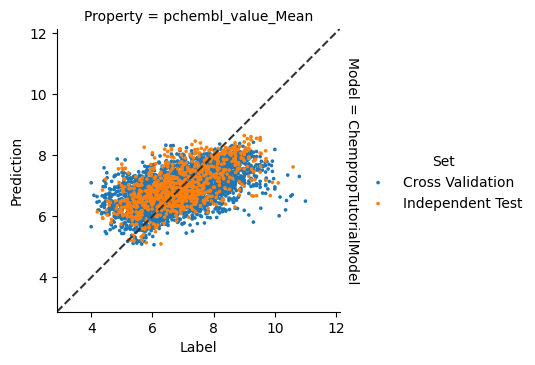

<Figure size 640x480 with 0 Axes>

In [6]:
from qsprpred.plotting.regression import CorrelationPlot

plot = CorrelationPlot([model])
axes, summary = plot.make(save=False, show=True)

In [7]:
summary

,Model,Fold,Property,R2,RMSE,Set
0,ChempropTutorialModel,0.0,pchembl_value_Mean,0.364764,0.923366,Cross Validation
1,ChempropTutorialModel,1.0,pchembl_value_Mean,0.274390,1.001930,Cross Validation
2,ChempropTutorialModel,2.0,pchembl_value_Mean,0.319186,0.946741,Cross Validation
3,ChempropTutorialModel,3.0,pchembl_value_Mean,0.278532,0.965912,Cross Validation
4,ChempropTutorialModel,4.0,pchembl_value_Mean,0.233830,1.025186,Cross Validation
5,ChempropTutorialModel,Independent Test,pchembl_value_Mean,0.362437,0.937360,Independent Test
